## About learning rate

https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/

![picture](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png)

We can schedule the learning rate based on current epoch and predefined function automatically.

## Data Prep

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import LearningRateScheduler
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train'], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteTS9I3I/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2
DATASET_SIZE = len(dataset[0])

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(buffer_size=8).batch(BATCH_SIZE)

In [6]:
model = tf.keras.Sequential([InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                             Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Flatten(),

                             Dense(100, activation='sigmoid'),
                             BatchNormalization(),
                             Dense(10, activation='sigmoid'),
                             BatchNormalization(),
                             Dense(1, activation='sigmoid')]) # 0 or 1
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

## Learning Rate Scheduler

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

Purpose of using it?
- speed
- stability

In [7]:
def scheduler(epoch, lr):
  ## epoch starts from 0? 1?
  if epoch <= 2: # This function keeps the initial learning rate for the first three epochs
    return lr
  else:
    return lr * tf.math.exp(-0.1) # and decreases it exponentially after that.
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [9]:
metrics = [BinaryAccuracy(name='accuracy'),
           Precision(name='precision'),
           Recall(name='recall'),
           AUC(name='auc')]
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=metrics)
history = model.fit(train_dataset, validation_data=val_dataset, callbacks=[scheduler_callback], epochs=5, verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
517/517 [==============================] - 83s 133ms/step - loss: 0.6650 - accuracy: 0.6340 - precision: 0.6261 - recall: 0.6638 - auc: 0.6790 - val_loss: 0.6616 - val_accuracy: 0.6282 - val_precision: 0.6273 - val_recall: 0.6353 - val_auc: 0.6720 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
517/517 [==============================] - 41s 80ms/step - loss: 0.6317 - accuracy: 0.6505 - precision: 0.6376 - recall: 0.6963 - auc: 0.6984 - val_loss: 0.7299 - val_accuracy: 0.5240 - val_precision: 0.5134 - val_recall: 0.9779 - val_auc: 0.5812 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/5
517/517 [==============================] - 41s 79ms/step - loss: 0.6420 - accuracy: 0.6361 - precision: 0.6224 - recall: 0.6909 - auc: 0.6800 - val_loss: 0.6759 - val_accuracy: 0.5872 - val_precision: 0.5556 -

## Advanced Learning Rate Schedules

https://mxnet.apache.org/versions/1.7/api/python/docs/tutorials/packages/gluon/training/learning_rates/learning_rate_schedules_advanced.html

In [ ]:
!pip install mxnet

In [12]:
import copy
import math
import mxnet as mx
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

### Slant triangular

In [14]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

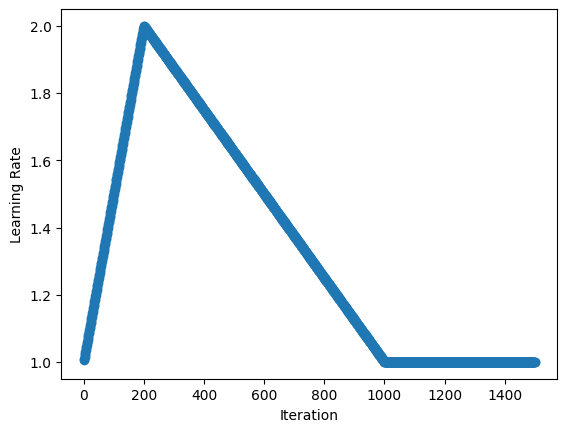

In [15]:
schedule = TriangularSchedule(min_lr=1, max_lr=2, cycle_length=1000, inc_fraction=0.2)
plot_schedule(schedule)

- A smooth linear warm up in the learning rate at the start of training improved the stability of the optimizer and lead to better solutions. (Goyal et al., 2017)
- “triangular” schedule (Smith, 2015) -> the schedule linearly increases then decreases between a lower and upper bound
- “slanted triangular” schedule (Howard & Ruder, 2018) -> change the ratio between the increasing and decreasing stages, instead of the 50:50 split. Changing the increasing fraction (inc_fraction!=0.5) leads to a “slanted triangular” schedule. Using inc_fraction<0.5 tends to give better results.

### Stepwise decay function

In [16]:
class LinearWarmUp():
    def __init__(self, schedule, start_lr, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        start_lr: learning rate used at start of the warm-up (float)
        length: number of iterations used for the warm-up (int)
        """
        self.schedule = schedule
        self.start_lr = start_lr
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.finish_lr = copy.copy(schedule)(0)
        self.length = length

    def __call__(self, iteration):
        if iteration <= self.length:
            return iteration * (self.finish_lr - self.start_lr)/(self.length) + self.start_lr
        else:
            return self.schedule(iteration - self.length)

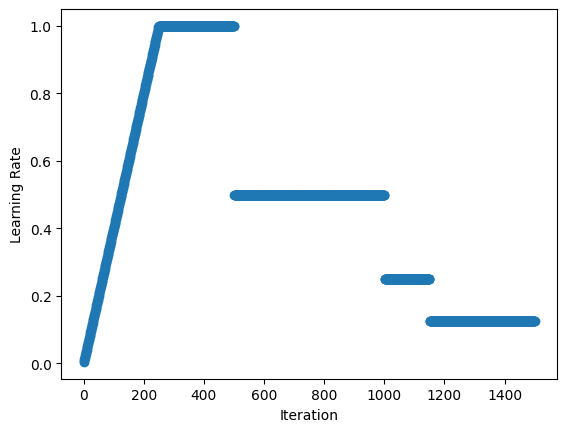

In [17]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
schedule = LinearWarmUp(schedule, start_lr=0, length=250)
plot_schedule(schedule)

### Cyclical

repeat cycles, each with a length of 500 iterations and lower and upper learning rate bounds of 0.5 and 2 respectively.



In [18]:
class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

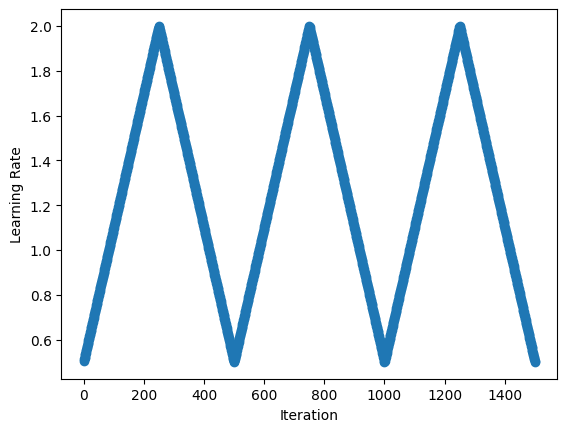

In [19]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
plot_schedule(schedule)